In [1]:
import os
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

In [2]:
print(f"PyTorch Version: {torch.__version__}")
print(f"PyTorchVision Version: {torchvision.__version__}")
# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = (
    "mps"
    if torch.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

PyTorch Version: 2.5.1
PyTorchVision Version: 0.20.1
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [24]:
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import os
from torchvision import tv_tensors

def parse_yolo_labels(label_file, img_width, img_height):
    with open(label_file, 'r') as f:
        boxes = []
        labels = []
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            
            # Convert YOLO format to pixel coordinates
            x_min = (x_center - width / 2) * img_width
            y_min = (y_center - height / 2) * img_height
            x_max = (x_center + width / 2) * img_width
            y_max = (y_center + height / 2) * img_height
            
            # Ensure coordinates are within image bounds
            x_min = max(0, min(x_min, img_width))
            y_min = max(0, min(y_min, img_height))
            x_max = max(0, min(x_max, img_width))
            y_max = max(0, min(y_max, img_height))
            
            # Convert to integers
            boxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(class_id)
        return boxes, labels

class ObjectDetectionDataset(Dataset):
    def __init__(self, image_dir, split_label_dir):
        self.image_dir = image_dir
        self.split_label_dir = split_label_dir
        
        # First get all label files in the split directory
        self.label_files = [f for f in os.listdir(split_label_dir) if f.endswith(".txt")]
        print(f"Found {len(self.label_files)} labels in {split_label_dir}")
        
        # Get corresponding image files
        self.image_files = []
        for label_file in self.label_files:
            img_file = label_file.replace(".txt", ".jpg")
            if os.path.exists(os.path.join(image_dir, img_file)):
                self.image_files.append(img_file)
            else:
                print(f"Warning: Image file not found for {label_file}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get label file path
        label_file = self.label_files[idx]
        image_file = label_file.replace(".txt", ".jpg")
        
        # Load image
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert("RGB")
        img_width, img_height = image.size
        
        # Load label
        label_path = os.path.join(self.split_label_dir, label_file)
        if os.path.exists(label_path):
            bboxes, labels = parse_yolo_labels(label_path, img_width, img_height)
        else:
            bboxes, labels = [], []
            print(f"Warning: Label file not found: {label_path}")
        
        # Convert to PyTorch tensors
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Convert PIL Image to tensor
        image = torch.FloatTensor(np.array(image)).permute(2, 0, 1) / 255.0
        
        # Create target dictionary similar to PennFudan format
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(bboxes, format="XYXY", canvas_size=(img_height, img_width))
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        # Calculate areas of boxes
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        # Set iscrowd to 0 for all instances
        target["iscrowd"] = torch.zeros((len(labels),), dtype=torch.int64)
        
        # Convert image to tv_tensors.Image
        image = tv_tensors.Image(image)
        
        return image, target

# Define directories
image_dir = "../data/renamed_dub_removed"
label_dirs = {
    "train": "../data/renamed_dub_removed/labels/yolo_txt/train",
    "val": "../data/renamed_dub_removed/labels/yolo_txt/val",
    "test": "../data/renamed_dub_removed/labels/yolo_txt/test"
}

# Create datasets for train, val, and test
datasets = {
    split: ObjectDetectionDataset(
        image_dir=image_dir,
        split_label_dir=label_dirs[split]
    )
    for split in label_dirs.keys()
}

# Test the dataset
for i in range(min(10, len(datasets["train"]))):
    image, target = datasets["train"][i]
    print(f"\nSample {i}:")
    print(f"Image shape: {image.shape}")
    print(f"Bounding boxes: {target['boxes']}")
    print(f"Labels: {target['labels']}")
    if len(target['labels']) > 0:
        break
        # Test that labels are being parsed correctly
        for split in ['train', 'val', 'test']:
            dataset = datasets[split]
            print(f"\nChecking {split} dataset:")
            print(f"Number of images: {len(dataset)}")
            
            # Test a few samples
            for i in range(min(3, len(dataset))):
                sample = dataset[i]
                print(f"\nSample {i}:")
                print(f"Image shape: {sample['image'].shape}")
                print(f"Number of bboxes: {len(sample['bboxes'])}")
                print(f"Number of labels: {len(sample['labels'])}")
                
                # Verify that bboxes and labels match
                assert len(sample['bboxes']) == len(sample['labels']), \
                    f"Number of bboxes ({len(sample['bboxes'])}) doesn't match number of labels ({len(sample['labels'])})"
                
                # Verify image dimensions are valid
                assert sample['image'].shape[0] == 3, "Image should have 3 channels (RGB)"
                assert sample['image'].min() >= 0 and sample['image'].max() <= 1, "Image values should be normalized between 0 and 1"

Found 1080 labels in ../data/renamed_dub_removed/labels/yolo_txt/train
Found 393 labels in ../data/renamed_dub_removed/labels/yolo_txt/val
Found 279 labels in ../data/renamed_dub_removed/labels/yolo_txt/test

Sample 0:
Image shape: torch.Size([3, 1130, 1300])
Bounding boxes: BoundingBoxes([[ 125.,    0., 1160., 1042.]], format=BoundingBoxFormat.XYXY, canvas_size=(1130, 1300))
Labels: tensor([8])


In [25]:
# plot the image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(sample):
    fig, ax = plt.subplots(1)
    ax.imshow(sample["image"].permute(1, 2, 0))
    
    for bbox, label in zip(sample["bboxes"], sample["labels"]):
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=1, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min, f"{label.item()}", color="r")
    
    plt.show();

Image shape: torch.Size([3, 1216, 1600])
Bounding boxes: BoundingBoxes([[   0.,   85., 1509., 1216.]], format=BoundingBoxFormat.XYXY, canvas_size=(1216, 1600))
Labels: tensor([12])


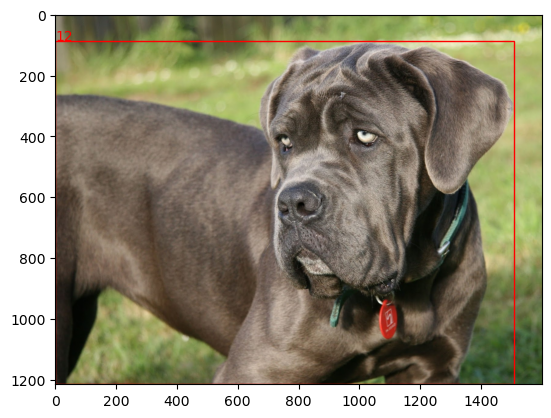

In [27]:
# Example: Access a sample from the train dataset
image, target = datasets["train"][2]
print(f"Image shape: {image.shape}")
print(f"Bounding boxes: {target['boxes']}")
print(f"Labels: {target['labels']}")
sample_dict = {"image": image, "bboxes": target["boxes"], "labels": target["labels"]}
plot_image_with_boxes(sample_dict)

Image shape: torch.Size([3, 332, 500])
Bounding boxes: BoundingBoxes([[205., 115., 311., 292.]], format=BoundingBoxFormat.XYXY, canvas_size=(332, 500))
Labels: tensor([2])


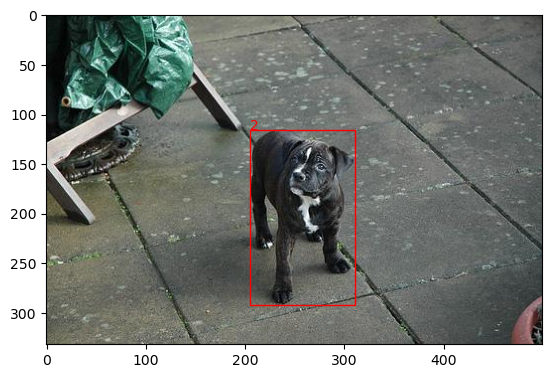

In [29]:
# Example: Access a sample from the val dataset
image, target = datasets["val"][200]
print(f"Image shape: {image.shape}")
print(f"Bounding boxes: {target['boxes']}")
print(f"Labels: {target['labels']}")
sample_dict = {"image": image, "bboxes": target["boxes"], "labels": target["labels"]}
plot_image_with_boxes(sample_dict)

In [31]:
from torch.utils.data import DataLoader

# Define data loaders
data_loaders = {
    split: DataLoader(datasets[split], batch_size=2, shuffle=True, collate_fn=lambda x: x)
    for split in ["train", "val", "test"]
}

# Example: Iterate over the training data loader
for batch in data_loaders["train"]:
    # Each item in batch is a tuple of (image, target)
    images = [item[0] for item in batch]
    bboxes = [item[1]["boxes"] for item in batch]
    labels = [item[1]["labels"] for item in batch]
    print(f"Batch of images: {len(images)}")
    print(f"Batch of bounding boxes: {bboxes}")
    print(f"Batch of labels: {labels}")
    break

Batch of images: 2
Batch of bounding boxes: [BoundingBoxes([[  7.,   2., 346., 400.]], format=BoundingBoxFormat.XYXY, canvas_size=(400, 355)), BoundingBoxes([[ 509.,  104., 1007.,  679.],
               [  40.,  201.,  546.,  917.]], format=BoundingBoxFormat.XYXY, canvas_size=(1078, 1080))]
Batch of labels: [tensor([12]), tensor([8, 8])]


In [36]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 19  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [38]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=["0"], output_size=7, sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=19,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
)


In [39]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_detection(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # # now get the number of input features for the mask classifier
    # in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # hidden_layer = 256
    # # and replace the mask predictor with a new one
    # model.roi_heads.mask_predictor = MaskRCNNPredictor(
    #     in_features_mask, hidden_layer, num_classes
    # )

    return model

In [42]:
# 19 classes; 18 target classes and background
num_classes = 19
num_epochs = 10
model = get_model_instance_detection(num_classes)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/tillmeineke/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:26<00:00, 6.72MB/s] 


In [43]:
# move model to the right device
model.to(device)
device

'mps'

In [44]:
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [51]:
len_dataloader = len(data_loaders["train"])

for epoch in range(num_epochs):
    model.train()
    i = 0
    for imgs, targets in data_loaders["train"]:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) if isinstance(v, (torch.Tensor, torchvision.tv_tensors.TVTensor)) else v 
                   for k, v in t.items()} for t in targets]
        
        # Check tensor dimensions
        print(f"Images shape before: {imgs.shape}")

        # Ensure imgs has 4 dimensions [batch, channels, height, width]
        if len(imgs.shape) == 3:
            # Add batch dimension if missing
            imgs = imgs.unsqueeze(0)

        print(f"Images shape after: {imgs.shape}")

        # Now pass to model
        loss_dict = model(imgs, targets)  # Changed 'annotations' to 'targets'
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"Iteration: {i}/{len_dataloader}, Loss: {losses}")


AttributeError: 'dict' object has no attribute 'to'

## Augmentation

In [20]:
# Image Classification
import torch
from torchvision.transforms import v2

H, W = 32, 32
img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)

transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img = transforms(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.605142].


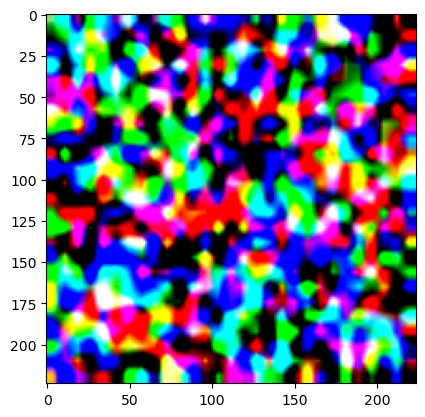

In [22]:
# plot image
import matplotlib.pyplot as plt
plt.imshow(img.permute(1, 2, 0))
plt.show();

In [28]:
# Detection (re-using imports and transforms from above)
from torchvision import tv_tensors

img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)
boxes = torch.randint(0, H // 2, size=(3, 4))
boxes[:, 2:] += boxes[:, :2]
boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=(H, W))

# The same transforms can be used!
img, boxes = transforms(img, boxes)
# And you can pass arbitrary input structures
output_dict = transforms({"image": img, "boxes": boxes})

In [29]:
device

'mps'

In [30]:
img, boxes

(tensor([[[ 1.7009,  1.7009,  1.7009,  ..., -1.4672, -1.4672, -1.4672],
          [ 1.7009,  1.7009,  1.7009,  ..., -1.4672, -1.4672, -1.4672],
          [ 1.7009,  1.7009,  1.7009,  ..., -1.4672, -1.4672, -1.4672],
          ...,
          [ 0.9474,  0.9474,  0.9474,  ...,  1.7694,  1.7694,  1.7694],
          [ 0.9474,  0.9474,  0.9474,  ...,  1.7694,  1.7694,  1.7694],
          [ 0.9474,  0.9474,  0.9474,  ...,  1.7694,  1.7694,  1.7694]],
 
         [[ 2.1835,  2.1835,  2.1835,  ...,  0.3102,  0.3102,  0.3102],
          [ 2.1835,  2.1835,  2.1835,  ...,  0.3102,  0.3102,  0.3102],
          [ 2.1835,  2.1835,  2.1835,  ...,  0.3102,  0.3102,  0.3102],
          ...,
          [-1.9132, -1.9132, -1.9132,  ...,  0.9755,  0.9755,  0.9755],
          [-1.9132, -1.9132, -1.9132,  ...,  0.9755,  0.9755,  0.9755],
          [-1.9132, -1.9132, -1.9132,  ...,  0.9755,  0.9755,  0.9755]],
 
         [[ 1.1411,  1.1411,  1.1411,  ..., -0.5670, -0.5670, -0.5670],
          [ 1.1411,  1.1411,

In [35]:
# plot image with boxes

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(img, boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(img.permute(1, 2, 0))
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=1, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
    plt.show();
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].


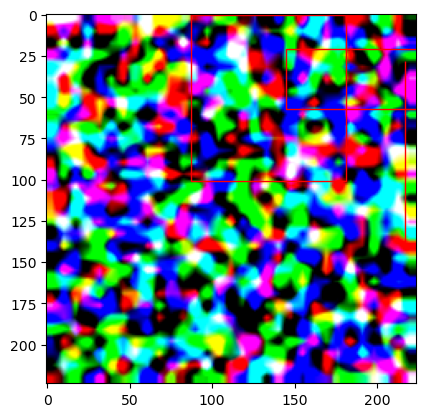

In [36]:
plot_image_with_boxes(img, boxes)